# <center>Welcome to oLIMpus Tutorial #3!</center>
### <center>By S. Libanore</center>
oLIMpus is based on a fully analytical effective model, and it allows to produce and study LIM auto- and cross- power spectra durning the EoR. 

Our work builds on the 21-cm effective model presented in Zeus21 (Munoz 2023), which is contained as a submodule in our package.

#### In this notebook you will learn how to...
- explore how varying parameters affect the LIM power spectra


## General definitions

In [1]:
import numpy as np 
from copy import copy 

from tqdm import tqdm

import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
from oLIMpus import analysis as a 

In Tutorial #1 we relied on the collective class from the **analysis.py** module to run oLIMpus and Zeus21. Here, instead, we run each function separately, so to explore the dependency on more parameters.

In [ ]:
# set user parameters, see inputs.py for details
UP = a.User_Parameters(
            precisionboost= 1.0, 
            FLAG_FORCE_LINEAR_CF= 0, 
            MIN_R_NONLINEAR= 0.5, 
            MAX_R_NONLINEAR= 200.0,
            FLAG_DO_DENS_NL= False, 
            FLAG_WF_ITERATIVE= True,
            )

# set fiducial cosmology, run CLASS and get the halo mass function
CP_fid, ClassyC_fid, zeus_corr_fid, HMFcl_fid = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))

# set line parameters
LineParams_Input_fid = a.LineParams_Input(
            LINE = 'OIII', # which line
            LINE_MODEL = 'Yang24', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in Jy/sr or mK
            _R = 1., # resolution for smoothing
            sigma_LMh = 0., # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True, # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
        )

LP_fid = a.Line_Parameters(LineParams_Input_fid,UP)

We create functions to vary some of the cosmological, astrophysical, and line parameters in the respective dictionaries. 

The user can follow a similar implementation to vary other parameters of interest.

In [ ]:
# vary cosmo params: primordial amplitude, matter density, primordial tilt
CosmoParams_input_var = lambda As, omegac, ns: dict(
        omegab= 0.0223828, 
        omegac = omegac, #fiducial : 0.1201075, 
        h_fid = 0.67810, 
        As = As, #fiducial : 2.100549e-09, 
        ns = ns, #fiducial : 0.9660499, 
        tau_fid = 0.05430842, 
        HMF_CHOICE= "ST",
        Flag_emulate_21cmfast = False,
        )

In [ ]:
# vary line properties: coefficient of the line-SFR power law
LineParams_Input_var = lambda line_dict: a.LineParams_Input(
            LINE = 'OIII', # which line
            LINE_MODEL = 'Yang24', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in Jy/sr or mK
            _R = 1., # resolution for smoothing
            sigma_LMh = 0., # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True, # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
                line_dict=line_dict
        )

LP_var = lambda line_dict: a.Line_Parameters(LineParams_Input_var(line_dict),UP)

# this is the dictionary containing the line parameters for the Yang24 model, see LIM_modeling.py
Yang24_OIII_params_var = lambda alpha: {
        'alpha': alpha, #fiducial : 9.82e-2,
        'beta': 6.90e-1,
        'N': 2.75e7,
        'SFR1': 1.24e2,
        }


The following function modifies the astrophysical parameters based on the user choice.

In [ ]:
# vary astro params: coefficient of the SFR power law on low masses, coefficients of the SFR power law on high masses, star formation efficiency, mass turn over (SFR is based on GALLUMI, see sfrd.py)
def change_astro(alphastar,betastar,epsstar,Mc,CP):

    AstroParams_input = copy(a.AstroParams_input_fid)
    if alphastar is not None:
        AstroParams_input['alphastar'] = alphastar
    if betastar is not None:
        AstroParams_input['betastar'] = betastar
    if epsstar is not None:
        AstroParams_input['epsstar'] = epsstar
    if Mc is not None:
        AstroParams_input['Mc'] = Mc
        
    AP = a.zeus21.Astro_Parameters(UP, CP, **AstroParams_input)
    
    return AP

The following function runs oLIMpus to get the LIM power spectra with varying parameters.

In [ ]:
def run_LIM(alphastar,betastar,epsstar,Mc, CosmoParams_input_here, line_dict):

    ZMIN = 5.
    RSD_MODE = 1

    if CosmoParams_input_here is not None:
        CP, ClassyC, zeus_corr, HMFcl = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**CosmoParams_input_here))
    else:
        CP = CP_fid
        ClassyC = ClassyC_fid
        zeus_corr = zeus_corr_fid
        HMFcl = HMFcl_fid

    LP = LP_var(line_dict)

    AP = change_astro(alphastar,betastar,epsstar,Mc,CP)

    LIM_coeff = a.get_LIM_coefficients(LP, AP, CP, HMFcl, UP, ZMIN)

    LIM_corr = a.Correlations_LIM(LP, CP, ClassyC)

    LIM_pk = a.Power_Spectra_LIM(LIM_corr, LIM_coeff, LP, CP, UP, RSD_MODE)

    return LIM_coeff, LIM_pk, ClassyC.Omega_m(), ClassyC.sigma8()


In [ ]:
# vary astro parameters
alpha_model = lambda alpha: run_LIM(alphastar=alpha,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=None, line_dict=None)

beta_model = lambda beta: run_LIM(alphastar=None,betastar=beta,epsstar=None,Mc=None,CosmoParams_input_here=None, line_dict=None)

epsstar_model = lambda epsstar: run_LIM(alphastar=None,betastar=None,epsstar=epsstar,Mc=None,CosmoParams_input_here=None, line_dict=None)

Mc_model = lambda Mc: run_LIM(alphastar=None,betastar=None,epsstar=None,Mc=Mc,CosmoParams_input_here=None, line_dict=None)

# vary line parameter
LIM_model = lambda alpha: run_LIM(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=None, line_dict=Yang24_OIII_params_var(alpha))

# vary cosmo parameters
As_model = lambda As: run_LIM(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=CosmoParams_input_var(As,a.CosmoParams_input_fid['omegac'],a.CosmoParams_input_fid['ns']), line_dict=None)

omegac_model = lambda omega_c: run_LIM(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=CosmoParams_input_var(a.CosmoParams_input_fid['As'],omega_c,a.CosmoParams_input_fid['ns']), line_dict=None)

ns_model = lambda ns: run_LIM(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=CosmoParams_input_var(a.CosmoParams_input_fid['As'],a.CosmoParams_input_fid['omegac'],ns), line_dict=None)

The following function runs Zeus21 to get the 21-cm power spectra with varying parameters.

In [ ]:
def run_21cm(alphastar,betastar,epsstar,Mc, CosmoParams_input_here):

    ZMIN = 5.
    RSD_MODE = 1

    if CosmoParams_input_here is not None:
        CP, ClassyC, zeus_corr, HMFcl = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**CosmoParams_input_here))
    else:
        CP = CP_fid
        ClassyC = ClassyC_fid
        zeus_corr = zeus_corr_fid
        HMFcl = HMFcl_fid

    AP = change_astro(alphastar,betastar,epsstar,Mc,CP)

    zeus_coeff = a.get_T21_coefficients(UP, CP, ClassyC, AP, HMFcl, ZMIN)

    zeus_pk = a.Power_Spectra(UP, CP, AP, ClassyC, zeus_corr, zeus_coeff, RSD_MODE)

    return zeus_coeff, zeus_pk, ClassyC.Omega_m(), ClassyC.sigma8()

In [4]:
# vary astro parameters 
alpha_model_21 = lambda alpha: run_21cm(alphastar=alpha,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=None)

beta_model_21 = lambda beta: run_21cm(alphastar=None,betastar=beta,epsstar=None,Mc=None,CosmoParams_input_here=None)

epsstar_model_21 = lambda epsstar: run_21cm(alphastar=None,betastar=None,epsstar=epsstar,Mc=None,CosmoParams_input_here=None)

Mc_model_21 = lambda Mc: run_21cm(alphastar=None,betastar=None,epsstar=None,Mc=Mc,CosmoParams_input_here=None)

# vary cosmo parameters
As_model_21 = lambda As: run_21cm(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=CosmoParams_input_var(As,a.CosmoParams_input_fid['omegac'],a.CosmoParams_input_fid['ns']))

omegac_model_21 = lambda omega_c: run_21cm(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=CosmoParams_input_var(a.CosmoParams_input_fid['As'],omega_c,a.CosmoParams_input_fid['ns']))

ns_model_21 = lambda ns: run_21cm(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=CosmoParams_input_var(a.CosmoParams_input_fid['As'],a.CosmoParams_input_fid['omegac'],ns))

# no dependence on the LIM parameter
LIM_model_21 = lambda alpha: run_21cm(alphastar=None,betastar=None,epsstar=None,Mc=None,CosmoParams_input_here=None)


In [ ]:
# set arrays of parameters to be varied
Npt = 50 # how many points 

epsstar_val = np.logspace(-3,-1,Npt)
Mc_val = np.logspace(9,13,Npt)
beta_star = np.linspace(-3,0,Npt)
alpha_star = np.linspace(0,3,Npt)

alpha_LIM_val = np.linspace(0.01,1,Npt)
As_val = np.linspace(2.100549e-09-5*0.034e-9,2.100549e-09+5*0.034e-9, Npt)
omega_c_val = np.linspace(0.1206-5*0.0021, 0.1206+5*0.0021, Npt)
ns_val = np.linspace(0.5, 1.5, Npt)

In [ ]:
# Custom colormaps
colors = [(1, 1, 1), (0, 0, 1)]  
colors_1 = [(1, 1, 1), (0, 0.5, 0.5)]  
colors_2 = [(1, 1, 1), (0.29, 0.0, 0.51)]  
colors_3 = [(1, 1, 1), (0., 0., 0.)]  
custom_cmap = LinearSegmentedColormap.from_list("white_to_blue", colors, N=len(beta_star))
custom_cmap_1 = LinearSegmentedColormap.from_list("white_to_ottanio", colors_1, N=len(beta_star))
custom_cmap_2 = LinearSegmentedColormap.from_list("white_to_violet", colors_2, N=len(beta_star))
custom_cmap_3 = LinearSegmentedColormap.from_list("white_to_black", colors_3, N=len(beta_star))
norm_1 = Normalize(vmin=beta_star[0], vmax=beta_star[-1])
norm = Normalize(vmin=epsstar_val[0], vmax=epsstar_val[-1])
norm_2 = Normalize(vmin=Mc_val[0], vmax=Mc_val[-1])
norm_3 = Normalize(vmin=alpha_LIM_val[0], vmax=alpha_LIM_val[-1])

colors_red =[(1, 1, 1), (0.5, 0, 0)] 
colors_orange = [(1, 1, 1), (1, 0.55, 0)]
colors_darkyellow = [(1, 1, 1), (0.8, 0.6, 0)]
colors_green = [(1, 1, 1), (0.5, 0.5, 0)]
custom_cmap_red = LinearSegmentedColormap.from_list("white_to_red", colors_red, N=len(beta_star))
custom_cmap_orange = LinearSegmentedColormap.from_list("white_to_orange", colors_orange, N=len(beta_star))
custom_cmap_darkyellow = LinearSegmentedColormap.from_list("white_to_darkyellow", colors_darkyellow, N=len(beta_star))
custom_cmap_green = LinearSegmentedColormap.from_list("white_to_green", colors_green, N=len(beta_star))
norm_red = Normalize(vmin=0.78, vmax=0.86)
norm_orange = Normalize(vmin=0.28, vmax= 0.34)
norm_darkyellow = Normalize(vmin=ns_val[0], vmax=ns_val[-1])
norm_green = Normalize(vmin=alpha_star[0], vmax=alpha_star[-1])


### LIM power spectrum 

  0%|          | 0/50 [00:00<?, ?it/s]/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:29: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:31: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)
  8%|▊         | 4/50 [01:22<15:47, 20.59s/it]/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_modeling.py:214: RuntimeWarning: overflow encountered in reciprocal
  integrand_P_shot_noise = dndlogM**-1 * (dndlogM * Ltab_curr)**2  # units Lsun2 Mpc-3 because of the delta Dirac ?
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_modeling.py:214: RuntimeWarning: invalid value encountered in multiply
  integrand_P_shot_noise = dndlogM**-1 * (dndlogM * Ltab_curr)**2  # units Lsun2 

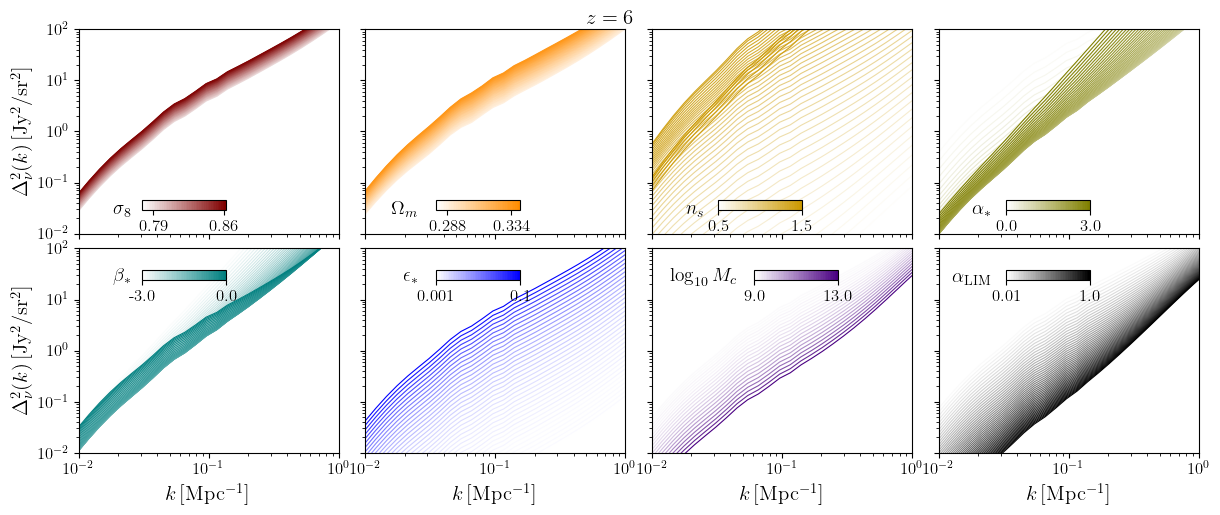

In [ ]:
# Create plot
fig, ax = plt.subplots(2,4,figsize=(12, 5),sharey=True,sharex=True)

use_z = 6.
s8 = np.zeros((Npt))
Om = np.zeros((Npt))
for i in tqdm(range(Npt)):

    LIM_coeff_h, LIM_pk_h, Om_h, s_h = As_model(As_val[i])
    LIM_coeff_omegac, LIM_pk_omegac, Om_omegac, s_omehac = omegac_model(omega_c_val[i])
    LIM_coeff_ns, LIM_pk_ns, _,_ = ns_model(ns_val[i])

    LIM_coeff, LIM_pk, _,_ = epsstar_model(epsstar_val[i])
    LIM_coeff_b, LIM_pk_b,_,_ = beta_model(-beta_star[i])
    LIM_coeff_m, LIM_pk_m,_,_ = Mc_model(Mc_val[i])
    LIM_coeff_a, LIM_pk_a,_,_ = alpha_model(alpha_star[i])

    LIM_coeff_line, LIM_pk_line,_,_ = LIM_model(alpha_LIM_val[i])

    zid = min(range(len(LIM_coeff.zintegral)), key=lambda i: np.abs((LIM_coeff.zintegral[i]-use_z))) 

    s8[i] = s_h
    Om[i] = Om_omegac

    klist = LIM_pk.klist_PS

    ax[0,0].loglog(klist, LIM_pk_h._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$\sigma_8=%g$'%s8[i],color = custom_cmap_red(norm_red(s8[i])),linewidth=0.8)
    ax[0,1].loglog(klist, LIM_pk_omegac._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$\Omega_m=%g$'%Om[i],color = custom_cmap_orange(norm_orange(Om[i])),linewidth=0.8)
    ax[0,2].loglog(klist, LIM_pk_ns._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$n_s=%g$'%ns_val[i],color = custom_cmap_darkyellow(norm_darkyellow(ns_val[i])),linewidth=0.8)

    ax[0,3].loglog(klist, LIM_pk_a._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$\alpha_*=%g$'%alpha_star[i],color = custom_cmap_green(norm_green(alpha_star[i])),linewidth=0.8)

    ax[1,0].loglog(klist, LIM_pk_b._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$\beta_*=%g$'%beta_star[i],color = custom_cmap_1(norm_1(beta_star[i])),linewidth=0.8)
    ax[1,1].loglog(klist, LIM_pk._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$\epsilon_*=%g$'%epsstar_val[i],color = custom_cmap(norm(epsstar_val[i])),linewidth=0.8)
    ax[1,2].loglog(klist, LIM_pk_m._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$M_c=%g$'%Mc_val[i],color = custom_cmap_2(norm_2(Mc_val[i])),linewidth=0.8)

    ax[1,3].loglog(klist, LIM_pk_line._Pk_LIM_tot[zid]*(klist**3/2/np.pi**2),label=r'$\alpha_{\rm LIM}=%g$'%alpha_LIM_val[i],color = custom_cmap_3(norm_3(alpha_LIM_val[i])),linewidth=0.8)

ax[0,0].set_ylabel(r'$\Delta^2_{\nu}(k)\,[{\rm Jy^2/sr^2}]$',fontsize=15)
ax[0,0].set_ylim(1e-2,1e2)
ax[0,0].set_xlim(1e-2,1)

ax[0,1].set_ylim(1e-2,1e2)
ax[0,1].set_xlim(1e-2,1)

ax[0,2].set_ylim(1e-2,1e2)
ax[0,2].set_xlim(1e-2,1)

ax[0,3].set_ylim(1e-2,1e2)
ax[0,3].set_xlim(1e-2,1)

ax[1,0].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,0].set_ylabel(r'$\Delta^2_{\nu}(k)\,[{\rm Jy^2/sr^2}]$',fontsize=15)
ax[1,0].set_ylim(1e-2,1e2)
ax[1,0].set_xlim(1e-2,1)

ax[1,1].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,1].set_ylim(1e-2,1e2)
ax[1,1].set_xlim(1e-2,1)

ax[1,2].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,2].set_ylim(1e-2,1e2)
ax[1,2].set_xlim(1e-2,1)

ax[1,3].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,3].set_ylim(1e-2,1e2)
ax[1,3].set_xlim(1e-2,1)

ax[0,0].text(0.025, 0.03, r'$\sigma_8$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,0], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.11, -0.39, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_red, norm=norm_red, orientation='horizontal')
cb.set_ticks([s8[0], s8[-1]])
cb.set_ticklabels([str(round(s8[0],2)), str(round(s8[-1],2))])

ax[0,1].text(0.025, 0.03, r'$\Omega_m$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,1], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.355, -0.39, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_orange, norm=norm_orange, orientation='horizontal')
cb.set_ticks([Om[0], Om[-1]])
cb.set_ticklabels([str(round(Om[0],3)), str(round(Om[-1],3))])

ax[0,2].text(0.025, 0.03, r'$n_s$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,2], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.59, -0.39, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_darkyellow, norm=norm_darkyellow, orientation='horizontal')
cb.set_ticks([ns_val[0], ns_val[-1]])
cb.set_ticklabels([str(ns_val[0]), str(ns_val[-1])])

ax[0,3].text(0.025, 0.03, r'$\alpha_*$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,3], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.83, -0.39, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_green, norm=norm_green, orientation='horizontal')
cb.set_ticks([alpha_star[0], alpha_star[-1]])
cb.set_ticklabels([str(alpha_star[0]), str(alpha_star[-1])])


# Add text for β_*
ax[1,0].text(0.025, 27.8, r'$\beta_*$', fontsize=14, ha='right', va='center')

# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,0], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.11, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_1, norm=norm_1, orientation='horizontal')
cb.set_ticks([beta_star[0], beta_star[-1]])
cb.set_ticklabels([str(beta_star[0]), str(beta_star[-1])])

ax[1,1].text(0.025, 27.8, r'$\epsilon_*$', fontsize=14, ha='right', va='center')

# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,1],  width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.355, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap, norm=norm, orientation='horizontal')
cb.set_ticks([epsstar_val[0], epsstar_val[-1]])
cb.set_ticklabels([str(epsstar_val[0]), str(epsstar_val[-1])])

ax[1,2].text(0.045, 27.8, r'$\log_{10}M_c$', fontsize=14, ha='right', va='center')

# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,2],  width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.62, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_2, norm=norm_2, orientation='horizontal')
cb.set_ticks([Mc_val[0], Mc_val[-1]])
cb.set_ticklabels([str(np.log10(Mc_val[0])), str(np.log10(Mc_val[-1]))])

ax[1,3].text(0.025, 27.8, r'$\alpha_{\rm LIM}$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,3], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.83, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_3, norm=norm_3, orientation='horizontal')
cb.set_ticks([alpha_LIM_val[0], alpha_LIM_val[-1]])
cb.set_ticklabels([str(alpha_LIM_val[0]), str(alpha_LIM_val[-1])])


plt.suptitle(r'$z=%g$'%use_z,y=.99)
plt.tight_layout(pad=0)
plt.savefig('../plots_paper1/LIM_vary_pars.png')


### 21-cm power spectrum 

 62%|██████▏   | 31/50 [1:00:20<36:54, 116.55s/it]/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/zeus21_local/zeus21/sfrd.py:257: RuntimeWarning: invalid value encountered in log
  self.gamma_II_index2D = np.log(SFRD_II_dR[:,:,midpoint+1]/SFRD_II_dR[:,:,midpoint-1]) / (deltaArray[:,:,0,midpoint+1] - deltaArray[:,:,0,midpoint-1])
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/zeus21_local/zeus21/sfrd.py:260: RuntimeWarning: invalid value encountered in log
  self.gamma_niondot_II_index2D = np.log(niondot_II_dR[:,:,midpoint+1]/niondot_II_dR[:,:,midpoint-1]) / (deltaArray[:,:,0,midpoint+1] - deltaArray[:,:,0,midpoint-1])
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/zeus21_local/zeus21/sfrd.py:271: RuntimeWarning: invalid value encountered in log
  der1_II =  np.log(SFRD_II_dR[:,:,midpoint]/SFRD_II_dR[:,:,midpoint-1])/(deltaArray[:,:,0,midpoint] - deltaArray[:,:,0,midpoint-1]) #ln(y2/y1)/(x2-x

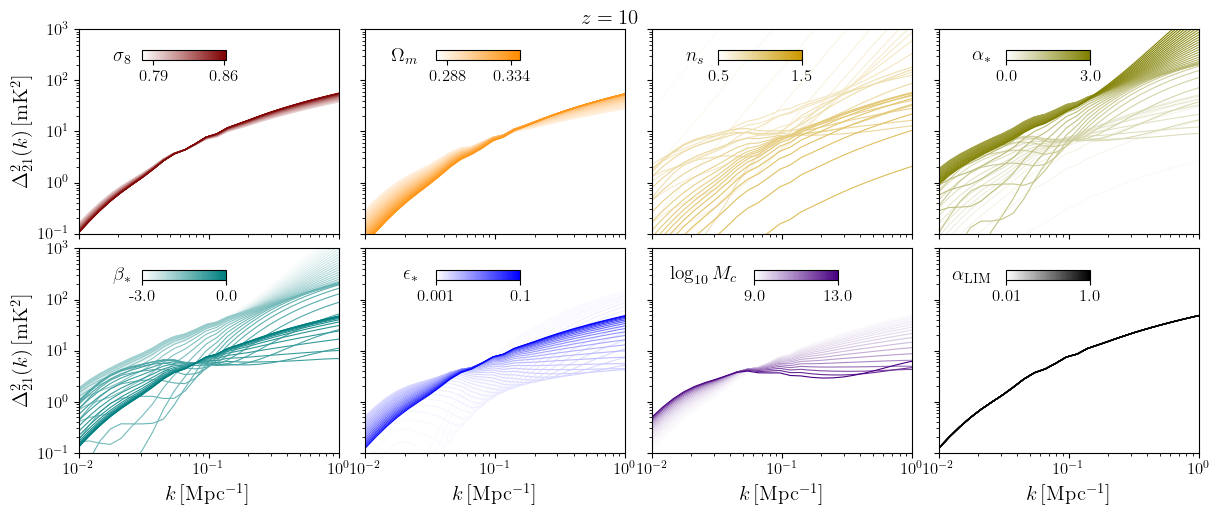

In [77]:
# Create plot
fig, ax = plt.subplots(2,4,figsize=(12, 5),sharey=True,sharex=True)

use_z = 10.
s8 = np.zeros((Npt))
Om = np.zeros((Npt))
for i in tqdm(range(Npt)):

    zeus_coeff_h, zeus_pk_h, Om_h, s_h = As_model_21(As_val[i])
    zeus_coeff_omegac, zeus_pk_omegac, Om_omegac, s_omegac = omegac_model_21(omega_c_val[i])
    zeus_coeff_ns, zeus_pk_ns,_,_ = ns_model_21(ns_val[i])

    zeus_coeff, zeus_pk ,_,_= epsstar_model_21(epsstar_val[i])
    zeus_coeff_b, zeus_pk_b ,_,_= beta_model_21(-beta_star[i])
    zeus_coeff_m, zeus_pk_m ,_,_= Mc_model_21(Mc_val[i])
    zeus_coeff_a, zeus_pk_a ,_,_= alpha_model_21(alpha_star[i])

    zeus_coeff_line, zeus_pk_line,_,_ = LIM_model_21(alpha_LIM_val[i])

    zid = min(range(len(zeus_coeff.zintegral)), key=lambda i: np.abs((zeus_coeff.zintegral[i]-use_z))) 

    s8[i] = s_h
    Om[i] = Om_omegac

    klist = zeus_pk.klist_PS

    ax[0,0].loglog(klist, zeus_pk_h.Deltasq_T21[zid],label=r'$\sigma_8=%g$'%s8[i],color = custom_cmap_red(norm_red(s8[i])),linewidth=0.8)
    ax[0,1].loglog(klist, zeus_pk_omegac.Deltasq_T21[zid],label=r'$\Omega_m=%g$'%Om[i],color = custom_cmap_orange(norm_orange(Om[i])),linewidth=0.8)
    ax[0,2].loglog(klist, zeus_pk_ns.Deltasq_T21[zid],label=r'$n_s=%g$'%ns_val[i],color = custom_cmap_darkyellow(norm_darkyellow(ns_val[i])),linewidth=0.8)

    ax[0,3].loglog(klist, zeus_pk_a.Deltasq_T21[zid],label=r'$\alpha_*=%g$'%alpha_star[i],color = custom_cmap_green(norm_green(alpha_star[i])),linewidth=0.8)

    ax[1,0].loglog(klist, zeus_pk_b.Deltasq_T21[zid],label=r'$\beta_*=%g$'%beta_star[i],color = custom_cmap_1(norm_1(beta_star[i])),linewidth=0.8)
    ax[1,1].loglog(klist, zeus_pk.Deltasq_T21[zid],label=r'$\epsilon_*=%g$'%epsstar_val[i],color = custom_cmap(norm(epsstar_val[i])),linewidth=0.8)
    ax[1,2].loglog(klist, zeus_pk_m.Deltasq_T21[zid],label=r'$M_c=%g$'%Mc_val[i],color = custom_cmap_2(norm_2(Mc_val[i])),linewidth=0.8)

    ax[1,3].loglog(klist, zeus_pk_line.Deltasq_T21[zid],label=r'$\alpha_{\rm LIM}=%g$'%alpha_LIM_val[i],color = custom_cmap_3(norm_3(alpha_LIM_val[i])),linewidth=0.8)

ax[0,0].set_ylabel(r'$\Delta^2_{21}(k)\,[{\rm mK^2}]$',fontsize=15)
ax[0,0].set_ylim(1e-1,1e3)
ax[0,0].set_xlim(1e-2,1)

ax[0,1].set_ylim(1e-1,1e3)
ax[0,1].set_xlim(1e-2,1)

ax[0,2].set_ylim(1e-1,1e3)
ax[0,2].set_xlim(1e-2,1)

ax[0,3].set_ylim(1e-1,1e3)
ax[0,3].set_xlim(1e-2,1)

ax[1,0].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,0].set_ylabel(r'$\Delta^2_{21}(k)\,[{\rm mK^2}]$',fontsize=15)
ax[1,0].set_ylim(1e-1,1e3)
ax[1,0].set_xlim(1e-2,1)

ax[1,1].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,1].set_ylim(1e-1,1e3)
ax[1,1].set_xlim(1e-2,1)

ax[1,2].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,2].set_ylim(1e-1,1e3)
ax[1,2].set_xlim(1e-2,1)

ax[1,3].set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=15)
ax[1,3].set_ylim(1e-1,1e3)
ax[1,3].set_xlim(1e-2,1)

ax[0,0].text(0.025, 300, r'$\sigma_8$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,0], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.11, -0.09, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_red, norm=norm_red, orientation='horizontal')
cb.set_ticks([s8[0], s8[-1]])
cb.set_ticklabels([str(round(s8[0],2)), str(round(s8[-1],2))])

ax[0,1].text(0.025, 300, r'$\Omega_m$', fontsize=14, ha='right', va='center')
# Add a small horizontal27.8 colorbar (as inset)
cax = inset_axes(ax[0,1], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.355, -0.09, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_orange, norm=norm_orange, orientation='horizontal')
cb.set_ticks([Om[0], Om[-1]])
cb.set_ticklabels([str(round(Om[0],3)), str(round(Om[-1],3))])

ax[0,2].text(0.025, 300, r'$n_s$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,2], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.59, -0.09, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_darkyellow, norm=norm_darkyellow, orientation='horizontal')
cb.set_ticks([ns_val[0], ns_val[-1]])
cb.set_ticklabels([str(ns_val[0]), str(ns_val[-1])])

ax[0,3].text(0.025, 300, r'$\alpha_*$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[0,3], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.83, -0.09, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_green, norm=norm_green, orientation='horizontal')
cb.set_ticks([alpha_star[0], alpha_star[-1]])
cb.set_ticklabels([str(alpha_star[0]), str(alpha_star[-1])])


# Add text for β_*
ax[1,0].text(0.025, 300, r'$\beta_*$', fontsize=14, ha='right', va='center')

# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,0], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.11, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_1, norm=norm_1, orientation='horizontal')
cb.set_ticks([beta_star[0], beta_star[-1]])
cb.set_ticklabels([str(beta_star[0]), str(beta_star[-1])])

ax[1,1].text(0.025, 300, r'$\epsilon_*$', fontsize=14, ha='right', va='center')

# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,1],  width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.355, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap, norm=norm, orientation='horizontal')
cb.set_ticks([epsstar_val[0], epsstar_val[-1]])
cb.set_ticklabels([str(epsstar_val[0]), str(epsstar_val[-1])])

ax[1,2].text(0.045, 300, r'$\log_{10}M_c$', fontsize=14, ha='right', va='center')

# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,2],  width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.62, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_2, norm=norm_2, orientation='horizontal')
cb.set_ticks([Mc_val[0], Mc_val[-1]])
cb.set_ticklabels([str(np.log10(Mc_val[0])), str(np.log10(Mc_val[-1]))])

ax[1,3].text(0.025, 300, r'$\alpha_{\rm LIM}$', fontsize=14, ha='right', va='center')
# Add a small horizontal colorbar (as inset)
cax = inset_axes(ax[1,3], width="7%", height="2%", loc='upper left',
                 bbox_to_anchor=(0.83, -0.53, 1, 1),
                 bbox_transform=fig.transFigure, borderpad=0)

cb = ColorbarBase(cax, cmap=custom_cmap_3, norm=norm_3, orientation='horizontal')
cb.set_ticks([alpha_LIM_val[0], alpha_LIM_val[-1]])
cb.set_ticklabels([str(alpha_LIM_val[0]), str(alpha_LIM_val[-1])])

plt.suptitle(r'$z=%g$'%use_z,y=.99)

plt.tight_layout(pad=0)
plt.savefig('../plots_paper1/21cm_vary_pars.png',dpi=300,bbox_inches='tight')


For further information, the user can refer to the documentation of each module, or contact the author at:

libanore@bgu.ac.il